In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

%matplotlib inline
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
sns.set_context("notebook")
plt.style.use('dark_background')
plt.rcParams["font.size"] = 18
np.random.seed(123)

In [2]:
df = pd.read_csv('./data/ch6_p3.csv', header=None)
df.columns = ['score']

In [6]:
stan_model = """
    data{
        int N;
        real X[N];
    }
    
    parameters{
        real mu;
        real<lower=0> sigma;
    }
    
    model{
        for(n in 1:N){
            X[n] ~ normal(mu, sigma);
        }
    }
    
    generated quantities{
        real<lower=0> score_90;
        real<lower=0, upper=1> b_prob;
        
        score_90 <- mu + 1.282 * sigma;
        b_prob <- 1 - normal_cdf(score_90, 87, 5);
    }
"""

In [7]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_04e7ed9727dd144da98f1084187969c4 NOW.


In [9]:
stan_data = {"N": df.shape[0], "X": df['score']}

In [10]:
fit = sm.sampling(data=stan_data, iter=11000, warmup=1000, chains=3, seed=1234)

In [11]:
fit

Inference for Stan model: anon_model_04e7ed9727dd144da98f1084187969c4.
3 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=30000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu        82.79  8.2e-3   1.22  80.39  81.99   82.8   83.6  85.19  22173    1.0
sigma      6.64  6.2e-3   0.93   5.12   5.99   6.54   7.18   8.75  22811    1.0
score_90  91.31    0.01   1.71  88.39  90.11  91.17  92.35  95.05  22707    1.0
b_prob     0.21  5.6e-4   0.09   0.05   0.14    0.2   0.27   0.39  25211    1.0
lp__     -69.16  9.3e-3   1.04 -71.99 -69.56 -68.84 -68.42 -68.15  12596    1.0

Samples were drawn using NUTS at Tue Aug 14 08:16:14 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

/Users/yugi/.pyenv/versions/anaconda-4.0.0/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


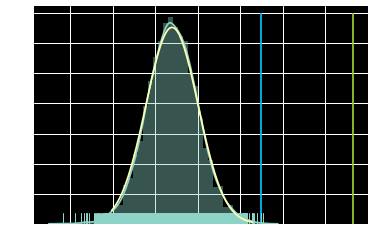

In [17]:
la = fit.extract(permuted=True) # サンプル列
names = fit.model_pars #パラメーター名from scipy.stats import norm, gamma
from scipy.stats import norm, gamma
u = la['mu'].mean()
s = la['mu'].std()
sns.distplot(la['mu'][:5000], kde=True,rug=True, norm_hist=False, bins=40)
x = np.linspace(norm.ppf(0.01, loc=u, scale=s), norm.ppf(0.999, loc=u, scale=s), 100)
plt.plot(x, norm.pdf(x=x, loc=u, scale=s))
plt.vlines(la['score_90'].mean(), 0, 0.35, colors='yellowgreen')
plt.vlines(87, 0, 0.35, colors='deepskyblue')